<a href="https://colab.research.google.com/gist/Pratyush/db9250576525169cc25a809979c9db04/marlin-piop-solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marlin PIOP Tutorial

Let's implement the non-holographic variant of the Marlin PIOP using the `ark_algebra_py` package. We'll start by installing it:

In [ ]:
!pip install --upgrade ark_algebra_py

## Overview of key classes

Now that it's installed, we can play around with it a little. The key classes that we'll be concerned with are `Scalar`, `Domain`, and `Polynomial`. We'll explain some common operations you can perform on these classes below, starting with `Scalar`.

`Scalar` represents an element of a finite field $\mathbb{F}$. For this tutorial, it doesn't really matter which field we use, but if you're curious, it's the scalar field of the BLS12-381 curve.

In [ ]:
from ark_algebra_py.ark_algebra_py import Scalar, Polynomial, Domain

a = Scalar(4);
b = Scalar(2);

print("a + b = ", a + b); # we can add...
print("a - b = ", a - b); # ... subtract ...
print("-a = ", -a);       # ... negate ...
print("a * b = ", a * b); # ... multiply ...
print("a * a^-1 = ", a * a.inverse()) # ... invert ...
print("random field element = ", Scalar.rand())
print("a ** 3 = ", a ** 3) # ... and exponentiate `Scalar`s.

`Polynomial`s are univariate polynomials over $\mathbb{F}$.

In [ ]:
# p(X) =          5      +   10 * X   + 20 * X**2
p = Polynomial([Scalar(5), Scalar(10), Scalar(20)])
q = Polynomial([Scalar(9), Scalar(14)])

print("p(5) = ", p.evaluate(Scalar(10))); # we can evaluate...
print("p + q = ", p + q); # ... add ...
print("p - q = ", p + q); # ... subtract ...
print("p * q = ", p * q); # ... multiply ...
print("p / q = ", p / q); # ... divide to get quotient and remainder ...
print("p.degree() = ", p.degree()); # ... and get the degree of polynomials

`Domain`s are succinct descriptions of subsets of $\mathbb{F}$ that support efficient interpolation algorithms, and whose vanishing polynomial can be evaluated succinctly.

In [ ]:
H = Domain(8); # create a subset of size 8

# Let's try to interpolate a polynomial from the list `a`:
a = [Scalar(1), Scalar(2), Scalar(3)]
a_hat = H.interpolate(a);

# Let's check that a_hat takes the correct values over `domain`:
assert(a_hat.evaluate(H.element(0)) == a[0])
assert(a_hat.evaluate(H.element(1)) == a[1])
assert(a_hat.evaluate(H.element(2)) == a[2])
assert(a_hat.evaluate(H.element(3)) == Scalar(0))
print(a_hat.divide_by_vanishing_poly(H))

assert(H.evaluate_vanishing_polynomial(H.element(5)) == Scalar(0))
# We can get the vanishing polynomial
assert(H.vanishing_polynomial().evaluate(H.element(5)) == Scalar(0))
print(H.elements())
assert(H.element(1).square() == H.element(2))

## PIOP for Zerocheck

We'll start simple by trying to construct a PIOP for Zerocheck. Recall that in the Zerocheck problem, the prover is trying to convince the verifier that the evaluations of a polynomial $p$ at all points in a domain $H$ are all $0$.

Let's start by writing out the prover and verifier code:

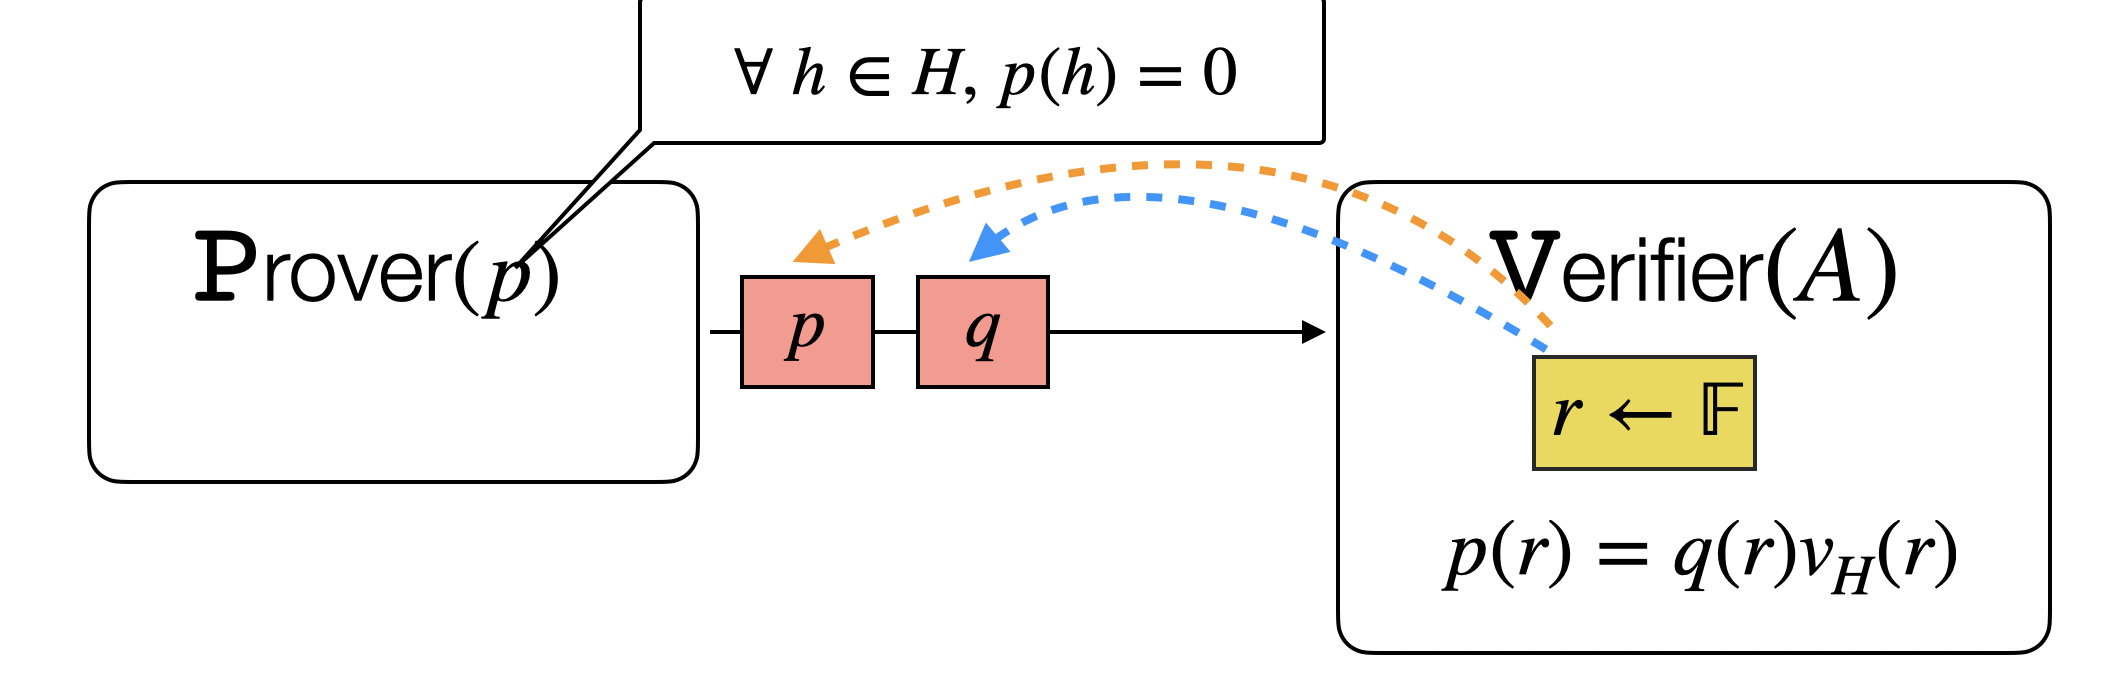

In [ ]:
def zero_check_prover(p, domain):
  (q, r) = p.divide_by_vanishing_poly(domain);
  return { "p": p, "q": q } # return a dictionary of polynomial oracles


def zero_check_verifier_query(domain):
  r = Scalar.rand()
  return { "p": r, "q": r } # Return a dictionary of (oracle_name, query)

def zero_check_decision(domain, queries, evaluations):
  r = queries["p"]
  # fill in your code here
  p_eval = evaluations["p"]
  q_eval = evaluations["q"]
  return p_eval == q_eval * domain.evaluate_vanishing_polynomial(r)

def eval_at_queries(oracles, queries):
  evaluations = {}
  for (oracle_name, point) in queries.items():
    evaluations[oracle_name] = oracles[oracle_name].evaluate(point)
  return evaluations

We want these functions to satisfy completeness...:

In [ ]:
# Completeness:

zero = Scalar(0)
# We'll use a multiple of the vanishing polynomial p(X) = 2 * X^8 - 2
p = Polynomial([Scalar(-2), zero, zero, zero, zero, zero, zero, zero, Scalar(2)])

oracles = zero_check_prover(p, Domain(8))
queries = zero_check_verifier_query(H)
evaluations = eval_at_queries(oracles, queries)
assert(zero_check_decision(H, queries, evaluations))

... and soundness:

In [ ]:
# Soundness:

zero = Scalar(0)
# We'll use a polynomial that is *almost* the same as before p(X) = 2 * X^8 - 3
p = Polynomial([Scalar(-3), zero, zero, zero, zero, zero, zero, zero, Scalar(2)])

oracles = zero_check_prover(p, Domain(8))
queries = zero_check_verifier_query(H)
evaluations = eval_at_queries(oracles, queries)
assert(zero_check_decision(H, queries, evaluations) == False)

## PIOP for Hadamard Products

With our PIOP for Zerocheck in hand, we're now ready to define our PIOP for Hadamard Product checks. Below is a reminder of what it looks like.

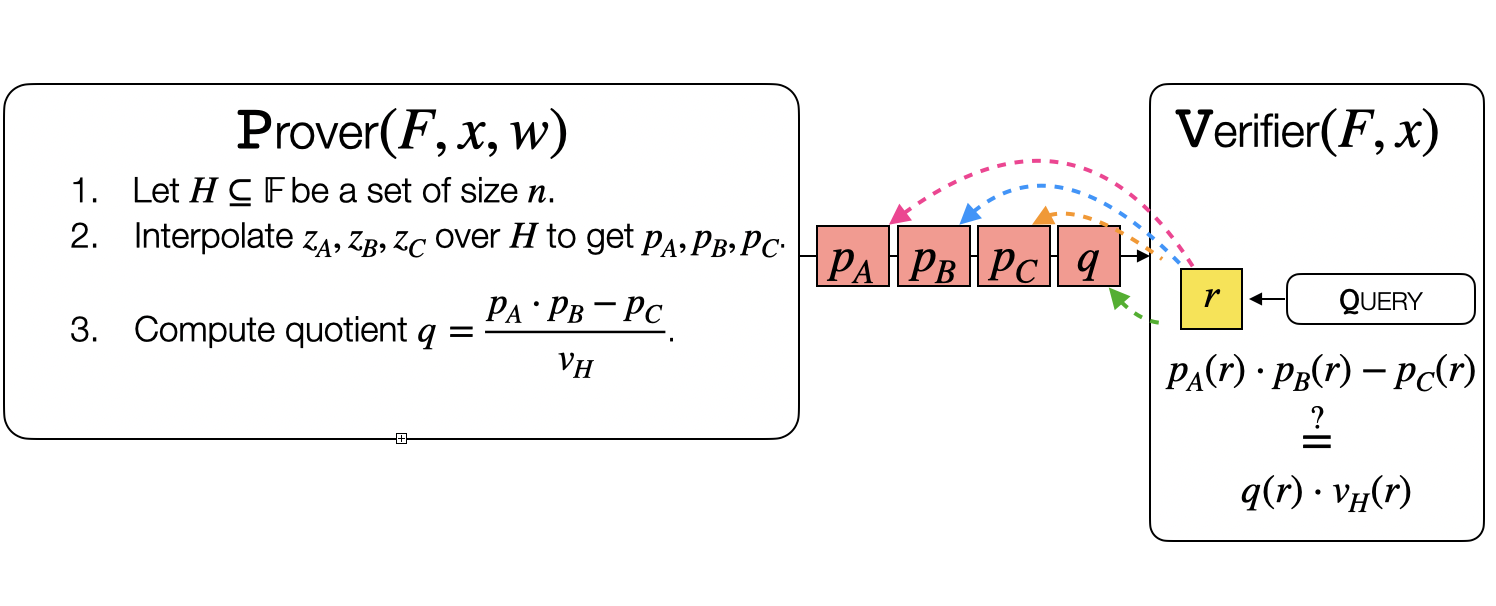

In [ ]:
def hadamard_prover(z_a, z_b, z_c, domain):
  p_a = domain.interpolate(z_a)
  p_b = domain.interpolate(z_b)
  p_c = domain.interpolate(z_c)
  return zero_check_prover(p_a * p_b - p_c, domain) # return a dictionary of polynomial oracles

def hadamard_verifier_query(domain):
  return zero_check_verifier_query(domain) # Return a dictionary of (oracle_name, query)

def hadamard_decision(domain, queries, evaluations):
  return zero_check_decision(domain, queries, evaluations)

Once again, we'll test completeness and soundness with respect to the following R1CS instance:

$$
A := \begin{pmatrix}
0 & 1 & 0 \\
0 & 2 & 0 \\
0 & 3 & 0 \\
\end{pmatrix};\;
B := \begin{pmatrix}
0 & 0 & 1 \\
0 & 0 & \frac12 \\
0 & 0 & \frac13 \\
\end{pmatrix};\;
C := \begin{pmatrix}
1 & 0 & 0 \\
1 & 0 & 0 \\
1 & 0 & 0 \\
\end{pmatrix};\;
$$

$$
x := 3
$$

In [ ]:
import numpy as np
one = Scalar(1)
two = one.double()
three = one + two
half = two.inverse()
third = three.inverse()
A = np.array([[zero, one, zero], [zero, two, zero], [zero, three, zero]])
B = np.array([[zero, zero, one], [zero, zero, half], [zero, zero, third]])
C = np.array([[one, zero, zero], [one, zero, zero], [one, zero, zero]])
x = np.array([Scalar(3)])

In [ ]:
# Completeness:
w = np.array([three.square(), third])
z = np.hstack([x, w]).transpose()
z_a = A @ z
z_b = B @ z
z_c = C @ z
assert(np.multiply(z_a, z_b) == z_c).all()


oracles = hadamard_prover(z_a, z_b, z_c, H)
queries = hadamard_verifier_query(H)
evaluations = eval_at_queries(oracles, queries)
assert(hadamard_decision(H, queries, evaluations))

In [ ]:
# Soundness:
w = np.array([three.square(), two])
z = np.hstack([x, w]).transpose()
z_a = A @ z
z_b = B @ z
z_c = C @ z
assert(np.multiply(z_a, z_b) != z_c).any()


oracles = hadamard_prover(z_a, z_b, z_c, H)
queries = hadamard_verifier_query(H)
evaluations = eval_at_queries(oracles, queries)
assert(hadamard_decision(H, queries, evaluations) == False)

## PIOP for Lincheck

Let's now design the PIOP for lincheck, based on the univariate sumcheck lemma. Recall that the latter is a statement of the form
$$\sum_{h \in H} p(h) = \sigma \iff \exists g, q \in \mathbb{F}[X] \text{ s.t. } p(X) = X \cdot g(X) + \frac{\sigma}{|H|} + q(X) v_H(X).$$

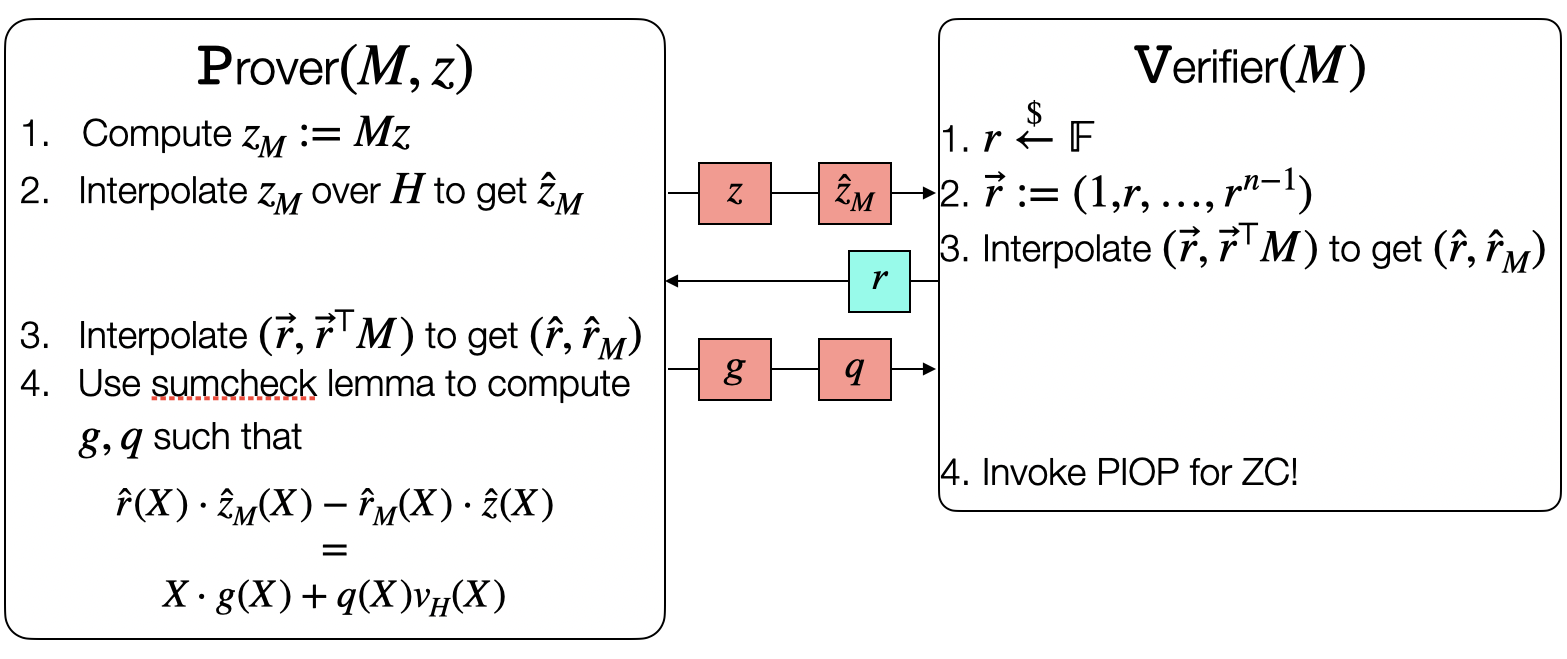

In [ ]:
def lincheck_prover_1(M, x, w, z_M, domain):
  z = list(np.hstack([x, w]))
  z_hat = domain.interpolate(z);
  z_m_hat = domain.interpolate(z_M);
  return {"z_hat": z_hat, "z_M_hat": z_m_hat} # return a dictionary of polynomial oracles


def lincheck_verifier_msg(domain):
  return Scalar.rand()

def lincheck_prover_2(M, x, w, z_M, verifier_msg, domain):
  oracles_1 = lincheck_prover_1(M, x, w, z_M, domain);
  z_hat = oracles_1["z_hat"]
  z_m_hat = oracles_1["z_M_hat"]
  r_vec = [verifier_msg**i for i in range(np.shape(M)[0])];
  r_hat = H.interpolate(r_vec)
  r_m = np.array(r_vec) @ M
  r_m_hat = H.interpolate(r_m)

  (q, g_prime) = (z_m_hat * r_hat - z_hat * r_m_hat).divide_by_vanishing_poly(H)
  (g, _) = g_prime / Polynomial.X()
  # fill in your code here
  return {"q": q, "g": g} # return a dictionary of polynomial oracles

def lincheck_verifier_query(verifier_msgs, domain):
  alpha = Scalar.rand()
  return {"z_hat": alpha, "z_M_hat": alpha, "q": alpha, "g": alpha } # Return a dictionary of (oracle_name, query)

def lincheck_decision(M, x, verifier_msgs, queries, domain, evaluations):
  r_vec = [verifier_msg**i for i in range(np.shape(M)[0])];
  alpha = queries["z_hat"]
  r_hat = H.interpolate(r_vec)
  r_m = np.array(r_vec) @ M
  r_m_hat = H.interpolate(r_m)
  z_hat_eval = evaluations["z_hat"]
  z_m_hat_eval = evaluations["z_M_hat"]
  q_eval = evaluations["q"]
  g_eval = evaluations["g"]
  return r_hat.evaluate(alpha) * z_m_hat_eval - r_m_hat.evaluate(alpha) * z_hat_eval == alpha * g_eval + q_eval * H.evaluate_vanishing_polynomial(alpha)

To check completeness and soundness, we'll focus on just a single matrix, $A$.

In [ ]:
# Completeness
w = np.array([three.square(), third])
z = np.hstack([x, w]).transpose()
z_a = A @ z

oracles_1 = lincheck_prover_1(A, x, w, z_a, H)
verifier_msg = lincheck_verifier_msg(H)
oracles_2 = lincheck_prover_2(A, x, w, z_a, verifier_msg, H)
queries = lincheck_verifier_query(verifier_msg, H)
evaluations = eval_at_queries(oracles_1 | oracles_2, queries)
assert(lincheck_decision(A, x, verifier_msg, queries, H, evaluations))

In [ ]:
# Soundness
w = np.array([three.square(), third])
z_a = np.array([one, one, two]).transpose()

oracles_1 = lincheck_prover_1(A, x, w, z_a, H)
verifier_msg = lincheck_verifier_msg(H)
oracles_2 = lincheck_prover_2(A, x, w, z_a, verifier_msg, H)
queries = lincheck_verifier_query(verifier_msg, H)
evaluations = eval_at_queries(oracles_1 | oracles_2, queries)
assert(lincheck_decision(A, x, verifier_msg, queries, H, evaluations) == False)